In [1]:
from encode import sample_files, get_dusted_units, get_hubert_units
from utils.features import DataSet
from pathlib import Path
import concurrent.futures

dataset = DataSet(
    name="librispeech-dev-clean",
    in_dir=Path("data/dev-clean"),
    align_dir=Path("data/alignments/dev-clean"),
    feat_dir=Path("features"), 
    audio_ext=".flac" 
)

sampled_paths = sample_files(dataset, 5)
print(len(sampled_paths))

5


In [3]:
from distance import load_units

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_hubert = executor.submit(load_units, dataset, sampled_paths, 0.0)
    future_dusted = executor.submit(load_units, dataset, sampled_paths, 0.2)

    hubert_words = future_hubert.result()
    dusted_words = future_dusted.result()

Loading Units: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]


In [20]:

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_hubert = executor.submit(get_hubert_units, dataset, sampled_paths)
    future_dusted = executor.submit(get_dusted_units, dataset, sampled_paths)

    hubert_words = future_hubert.result()
    dusted_words = future_dusted.result()

Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting DUSTED units: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


In [5]:
from collections import Counter

num_words = len(hubert_words)
true_words = []

avg_words = []
for w in range(num_words): 
    new_word = hubert_words[w].copy()
    hubert_units = hubert_words[w].clean_encoding
    dusted_units = dusted_words[w].clean_encoding

    common_units = list(dict.fromkeys(unit for unit in hubert_units if unit in dusted_units))
    new_word.update_encoding(common_units)
    avg_words.append(new_word)

    if not isinstance(new_word.true_word, str):
        true_words.append("_")
    else:
        true_words.append(new_word.true_word)

counts = Counter(true_words)
not_ones = {}
for c in counts:
    if counts[c] > 1:
        not_ones[c] = counts[c]
print(not_ones)


{'never': 2, '_': 12, 'it': 3, 'i': 2, 'was': 2, 'any': 2, 'had': 2, 'bright': 2, 'for': 3, 'he': 2, 'and': 3, 'a': 3, 'the': 4, 'of': 2}


In [6]:
import numpy as np 
from tqdm import tqdm
import editdistance

true_words = []
dusted_true_words = []
dist_mat_hub = np.zeros((num_words, num_words))
dist_mat_dust = np.zeros((num_words, num_words))
for i in tqdm(range(num_words), desc="Calculating Distances"):
    true_words.append(hubert_words[i].true_word)
    dusted_true_words.append(dusted_words[i].true_word)
    for j in range(i+1, num_words):
        dist_mat_hub[i, j] = editdistance.eval(hubert_words[i].clean_encoding, hubert_words[j].clean_encoding)
        dist_mat_hub[j, i] = dist_mat_hub[i, j]

        dist_mat_dust[i, j] = editdistance.eval(dusted_words[i].clean_encoding, dusted_words[j].clean_encoding)
        dist_mat_dust[j, i] = dist_mat_dust[i, j]

print(true_words)

Calculating Distances:   0%|          | 0/104 [00:00<?, ?it/s]

Calculating Distances: 100%|██████████| 104/104 [00:00<00:00, 3457.00it/s]

['never', '_', 'so', 'with', 'it', 'thought', 'i', 'seen', 'spots', 'was', 'blood', 'quickly', 'any', 'covered', 'red', '_', 'had', 'i', 'bright', 'bright', 'at', 'for', 'messenger', 'thirty', 'one', 'for', 'he', "rector's", 'him', '_', 'and', 'went', 'was', 'to', 'when', 'a', 'lunch', 'he', 'waiting', 'returned', 'a', 'depressing', '_', 'effect', '<unk>', 'loss', '_', 'friends', 'two', 'the', 'upon', 'mister', 'old', 'his', 'of', 'had', 'bread', 'besides', 'eats', 'extravagant', 'kind', 'of', 'making', 'use', 'heavy', 'and', 'it', 'for', '_', 'any', 'is', '_', '_', '_', 'very', 'as', 'never', 'new', 'toast', 'pairs', '_', 'it', 'and', 'advancing', 'presently', 'heard', 'were', 'over', '_', 'several', 'a', '_', 'along', 'the', 'through', 'feet', 'the', 'door', 'light', 'gleamed', 'seemed', 'the', 'window', 'passage']


/tmp/ipykernel_3414/2692290615.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_mat_dust, method='average')


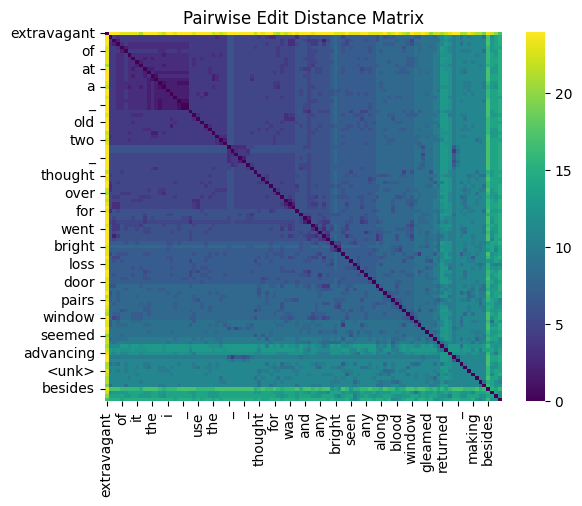

In [10]:
from cluster import cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

dist_df_dust = pd.DataFrame(dist_mat_dust, index=true_words, columns=true_words)
linked = linkage(dist_mat_dust, method='average')
order = leaves_list(linked)
reordered_dist_df = dist_df_dust.iloc[order, order]

plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

# dust_clusters = cluster(dist_mat_dust, 2)

# for d, d_clust in enumerate(dust_clusters):
#     if len(d_clust)>1:
#         print(f"Cluster {d}")
#         for k in range(len(d_clust)):
#             word_k = [w for w in dusted_words if w.id == d_clust[k]]
#             print(word_k[0].true_word)
#         print()

In [27]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=3, metric='precomputed')
nbrs.fit(dist_mat_dust)
distances, indices = nbrs.kneighbors(dist_mat_dust)
indices = indices[:, 1:] 

for i in range(len(indices)):
    if true_words[i] in not_ones:
        print(true_words[i])
        print(true_words[indices[i][0]], true_words[indices[i][1]])
        print()


never
never for

_
_ _

it
at the

i
had he

was
was is

any
lunch any

_
_ the

had
i he

i
the any

bright
bright light

bright
bright bread

for
for a

for
for feet

he
i had

_
_ _

and
and and

was
was when

a
a _

he
he had

a
a i

_
_ _

_
_ _

the
the i

of
of i

had
at he

of
of a

and
and and

it
it i

for
for feet

_
_ _

any
any and

_
_ _

_
_ _

_
_ _

never
never as

_
_ _

it
a it

and
and i

_
_ _

a
i at

_
_ _

the
the the

the
the it

the
the i



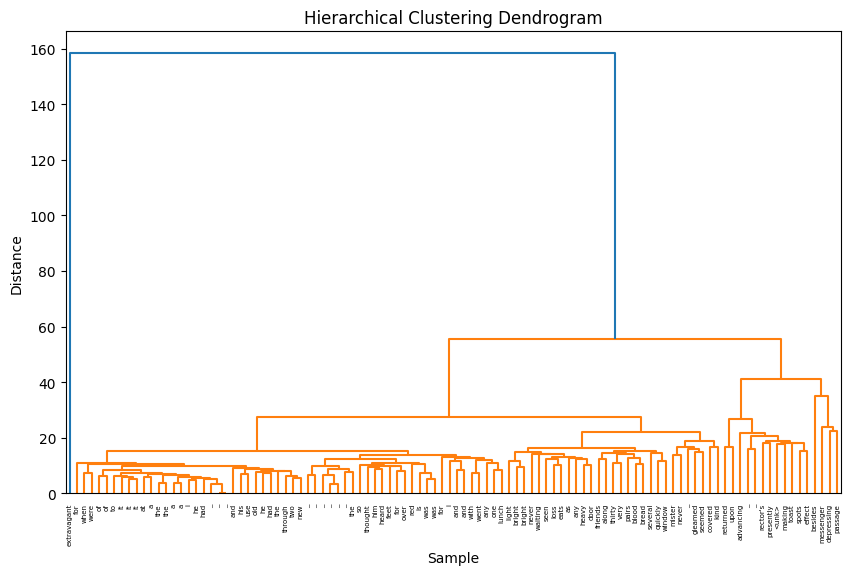

In [11]:
from scipy.cluster.hierarchy import dendrogram

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=true_words)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()

/tmp/ipykernel_3414/4108316786.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_df_hub, method='average')


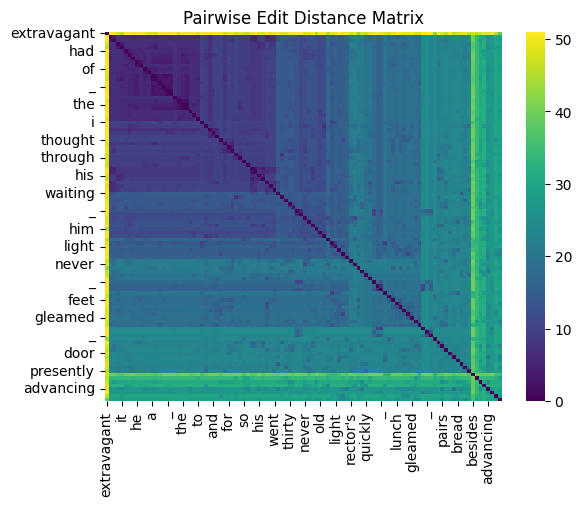

In [12]:
from cluster import cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

dist_df_hub = pd.DataFrame(dist_mat_hub, index=true_words, columns=true_words)
linked = linkage(dist_df_hub, method='average')
order = leaves_list(linked)
reordered_dist_df = dist_df_hub.iloc[order, order]

plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

# hub_clusters = cluster(dist_mat_hub, 3)

# for h, h_clust in enumerate(hub_clusters):
#     if len(h_clust)>1:
#         print(f"Cluster {h}")
#         for k in range(len(h_clust)):
#             word_k = [w for w in dusted_words if w.id == h_clust[k]]
#             print(word_k[0].true_word)
#         print()

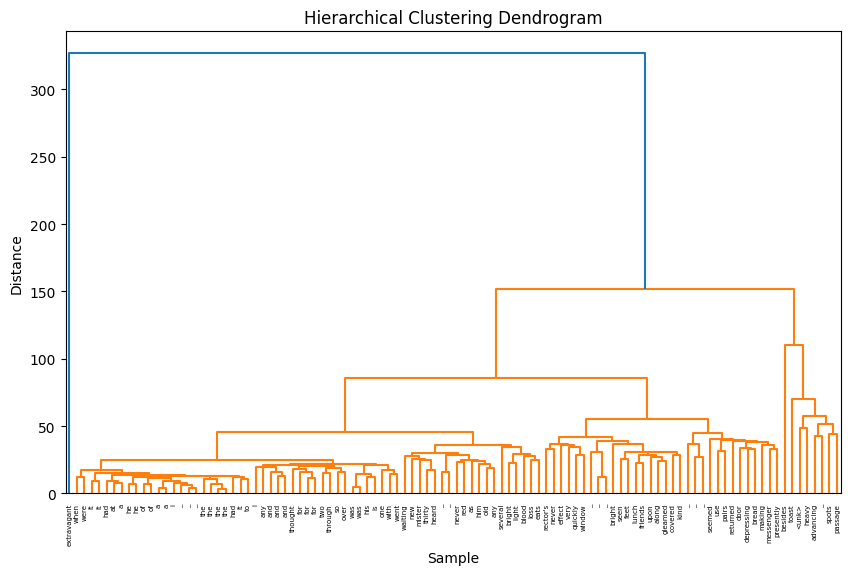

In [13]:
from scipy.cluster.hierarchy import dendrogram

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=true_words)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()